# Eager execution
**TensorFlow Dev Summit, 2018.**

This interactive notebook demonstrates **eager execution**, TensorFlow's imperative, NumPy-like front-end for machine learning.

> ![alt text](https://lh3.googleusercontent.com/QOvy0clmg7siaVKzwmSPAjicWWNQ0OeyaB16plDjSJMf35WD3vLjF6mz4CGrhSHw60HnlZPJjkyDCBzw5XOI0oBGSewyYw=s688)

**Table of Contents.**
1. _Enabling eager execution!_
2. _A NumPy-like library for numerical computation and machine learning. Case study: Fitting a huber regression_.
3. _Neural networks. Case study: Training a multi-layer RNN._
4. _Exercises: Batching; debugging._
5. _Further reading_

# 1. Enabling eager execution!

A single function call is all you need to enable eager execution: `tf.enable_eager_execution()`. You should invoke this function before calling into any other TensorFlow APIs --- the simplest way to satisfy this requirement is to make `tf.enable_eager_execution()` the first line of your `main` function.


In [0]:
!pip install -q -U tf-nightly

import tensorflow as tf

tf.enable_eager_execution()

# 2. A NumPy-like library for numerical computation and machine learning
Enabling eager execution transforms TensorFlow into an **imperative** library for numerical computation, automatic differentiation, and machine learning. When executing eagerly, _TensorFlow no longer behaves like a dataflow graph engine_: Tensors are backed by NumPy arrays (goodbye, placeholders!), and TensorFlow operations execute *immediately* via Python (goodbye, sessions!).

### Numpy-like usage

Tensors are backed by numpy arrays, which are accessible via their `.numpy()`
method.

In [0]:
A = tf.constant([[2.0, 0.0], [0.0, 3.0]])

In [3]:
import numpy as np

print("Tensors are backed by NumPy arrays, which are accessible through their "
      "`.numpy()` method:\n", A)
assert(type(A.numpy()) == np.ndarray)
print("\nOperations (like `tf.matmul(A, A)`) execute "
      "immediately (no more Sessions!):\n", tf.matmul(A, A))

Tensors are backed by NumPy arrays, which are accessible through their `.numpy()` method:
 tf.Tensor(
[[2. 0.]
 [0. 3.]], shape=(2, 2), dtype=float32)

Operations (like `tf.matmul(A, A)`) execute immediately (no more Sessions!):
 tf.Tensor(
[[4. 0.]
 [0. 9.]], shape=(2, 2), dtype=float32)


Tensors behave similarly to NumPy arrays, but they don't behave exactly the
same. 

For example, Tensors don't implement the equals operator in the natural
way.

In [4]:
print("\nTensors behave like NumPy arrays: you can iterate over them and "
      "supply them as inputs to most functions that expect NumPy arrays:")
for i, row in enumerate(A):
  for j, entry in enumerate(row):
    print("A[%d, %d]^2 == %d" % (i, j, np.square(entry)))


Tensors behave like NumPy arrays: you can iterate over them and supply them as inputs to most functions that expect NumPy arrays:
A[0, 0]^2 == 4
A[0, 1]^2 == 0
A[1, 0]^2 == 0
A[1, 1]^2 == 9


### Variables and Gradients

Create variables with `tf.contrib.eager.Variable`, and use `tf.GradientTape`
to compute gradients with respect to them.

In [5]:
import tensorflow.contrib.eager as tfe
w = tfe.Variable(3.0)
with tf.GradientTape() as tape:
  loss = w ** 2
dw, = tape.gradient(loss, [w])
print("\nYou can use `tf.GradientTape` to compute the gradient of a "
      "computation with respect to a list of `tf.contrib.eager.Variable`s;\n"
      "for example, `tape.gradient(loss, [w])`, where `loss` = w ** 2 and "
      "`w` == 3.0, yields`", dw,"`.")

Instructions for updating:
Use the retry module or similar alternatives.

You can use `tf.GradientTape` to compute the gradient of a computation with respect to a list of `tf.contrib.eager.Variable`s;
for example, `tape.gradient(loss, [w])`, where `loss` = w ** 2 and `w` == 3.0, yields` tf.Tensor(6.0, shape=(), dtype=float32) `.


### GPU usage
Eager execution lets you offload computation to hardware accelerators like
GPUs, if you have any available.

In [0]:
if tf.test.is_gpu_available() > 0:
  with tf.device(tf.test.gpu_device_name()):
    print(tf.matmul(A, A))

## Fitting a Huber regression

If you come from a scientific or numerical computing background, eager execution should feel natural to you. Not only does it stand on its own as an accelerator-compatible library for numerical computation, it also interoperates with popular Python packages like NumPy and Matplotlib. To demonstrate this fact, in this section, we fit and evaluate a regression using a [Huber regression](https://en.wikipedia.org/wiki/Huber_loss), writing our code in a NumPy-like way and making use of Python control flow.

### Data generation

Our dataset for this example has many outliers — least-squares would be a poor choice.

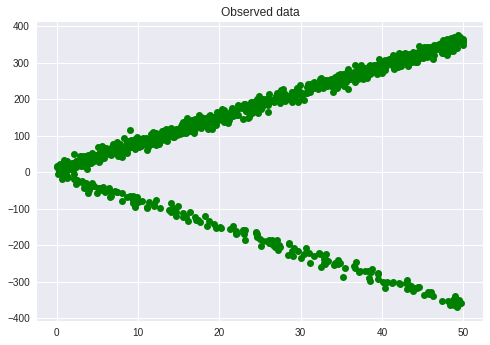

In [7]:
import matplotlib.pyplot as plt

def gen_regression_data(num_examples=1000, p=0.2):
  X = tf.random_uniform(shape=(num_examples,), maxval=50)
  w_star = tf.random_uniform(shape=(), maxval=10)
  b_star = tf.random_uniform(shape=(), maxval=10)
  noise = tf.random_normal(shape=(num_examples,), mean=0.0, stddev=10.0)
  # With probability 1 - p, y := y * -1.
  sign = 2 * np.random.binomial(1, 1 - p, size=(num_examples,)) - 1
  # You can freely mix Tensors and NumPy arrays in your computations:
  # `sign` is a NumPy array, but the other symbols below are Tensors.
  Y = sign * (w_star * X + b_star + noise)  
  return X, Y

X, Y = gen_regression_data()
plt.plot(X, Y, "go")  # You can plot Tensors!
plt.title("Observed data")
plt.show()

### Huber loss
The Huber loss function is piecewise function that is quadratic for small inputs and linear otherwise; for that reason, using a Huber loss gives considerably less weight to outliers than least-squares does. When eager execution is enabled, we can implement the Huber function in the natural way, using **Python control flow**.

In [0]:
def huber_loss(y, y_hat, m=1.0):
  # Enabling eager execution lets you use Python control flow.
  delta = tf.abs(y - y_hat)
  return delta ** 2 if delta <= m else m * (2 * delta - m)

### A simple class for regressions

The next cell encapsulates a linear regression model in a Python class and defines a
function that fits the model using a stochastic optimizer.

In [0]:
import time

from google.colab import widgets
import tensorflow.contrib.eager as tfe  # Needed to create tfe.Variable objects.


class Regression(object):
  def __init__(self, loss_fn):
    super(Regression, self).__init__()
    self.w = tfe.Variable(0.0)
    self.b = tfe.Variable(0.0)
    self.variables = [self.w, self.b]
    self.loss_fn = loss_fn
      
  def predict(self, x):
    return x * self.w + self.b
  
def regress(model, optimizer, dataset, epochs=5, log_every=1, num_examples=1000):
  plot = log_every is not None
  if plot:
    # Colab provides several widgets for interactive visualization.
    tb = widgets.TabBar([str(i) for i in range(epochs) if i % log_every == 0])
    X, Y = dataset.batch(num_examples).make_one_shot_iterator().get_next()
    X = tf.reshape(X, (num_examples,))
    Y = tf.reshape(Y, (num_examples,))
    
  for epoch in range(epochs):
    iterator = dataset.make_one_shot_iterator()
    epoch_loss = 0.0
    start = time.time()
    for x_i, y_i in iterator:
      batch_loss_fn = lambda: model.loss_fn(y_i, model.predict(x_i))  
      optimizer.minimize(batch_loss_fn, var_list=model.variables)
      epoch_loss += batch_loss_fn()
    duration = time.time() - start
    if plot and epoch % log_every == 0:
      with tb.output_to(str(epoch)):
        print("Epoch %d took %0.2f seconds, resulting in a loss of %0.4f." % (
            epoch, duration, epoch_loss))
        plt.plot(X, Y, "go", label="data")
        plt.plot(X, model.predict(X), "b", label="regression")
        plt.legend()

Run the following cell to fit the model! Note that enabling eager execution makes it
easy to visualize your model while training it, using  familiar tools like Matplotlib.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 0 took 1.16 seconds, resulting in a loss of 322937.2812.


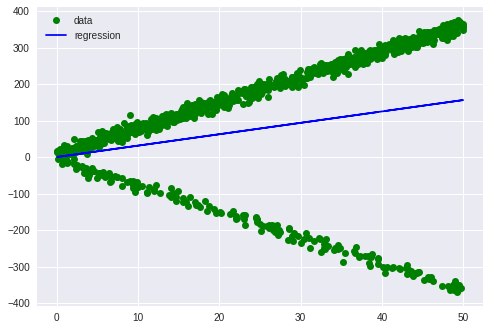

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1 took 1.24 seconds, resulting in a loss of 225539.1719.


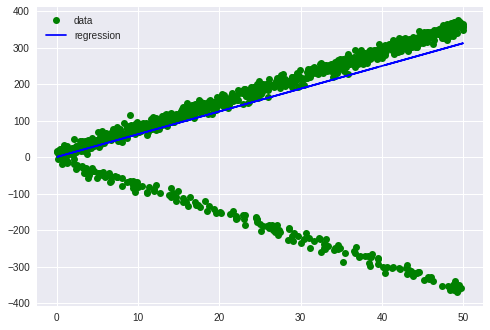

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 2 took 1.11 seconds, resulting in a loss of 157498.7812.


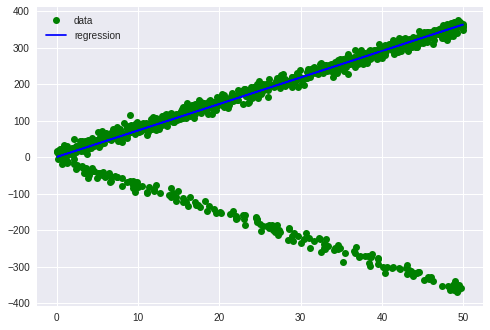

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 3 took 1.06 seconds, resulting in a loss of 154318.3906.


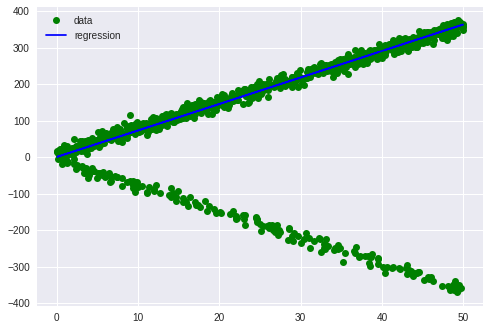

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 4 took 1.06 seconds, resulting in a loss of 154316.3906.


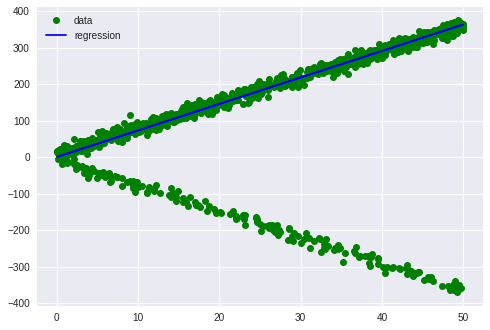

<IPython.core.display.Javascript object>

In [10]:
huber_regression = Regression(huber_loss)
dataset = tf.data.Dataset.from_tensor_slices((X, Y))
regress(huber_regression,
        optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0001),
        dataset=dataset)

## Debugging and profiling

### Enabling eager execution lets you debug your code on-the-fly; use `pdb` and print statements to your heart's content.

Check out exercise 2 towards the bottom of this notebook for a hands-on look at how eager simplifies model debugging.

In [11]:
import pdb

def buggy_loss(y, y_hat):
  pdb.set_trace()
  huber_loss(y, y_hat)
  
print("Type 'exit' to stop the debugger, or 's' to step into `huber_loss` and "
      "'n' to step through it.")
try:
  buggy_loss(1.0, 2.0)
except:
  pass

Type 'exit' to stop the debugger, or 's' to step into `huber_loss` and 'n' to step through it.
> <ipython-input-11-3cbc779c3bc6>(5)buggy_loss()
-> huber_loss(y, y_hat)
(Pdb) exit


### Leverage the Python profiler to dig into the relative costs of training your model.

If you run the below cell, you'll see that most of the time is spent computing gradients and binary operations, which is sensible considering our loss function.

In [12]:
import cProfile
import pstats

huber_regression = Regression(huber_loss)
cProfile.run(
    "regress(model=huber_regression, "
    "optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.001), "
    "dataset=dataset, log_every=None)", "prof")
pstats.Stats("prof").strip_dirs().sort_stats("cumulative").print_stats(10)
print("Most of the time is spent during backpropagation and binary operations.")

Thu Mar 29 17:50:31 2018    prof

         9274610 function calls (9254610 primitive calls) in 9.230 seconds

   Ordered by: cumulative time
   List reduced from 242 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    9.230    9.230 {built-in method builtins.exec}
        1    0.000    0.000    9.229    9.229 <string>:1(<module>)
        1    0.050    0.050    9.229    9.229 <ipython-input-9-a3af268753a3>:18(regress)
     5000    0.027    0.000    5.819    0.001 optimizer.py:341(minimize)
     5000    0.052    0.000    4.648    0.001 optimizer.py:402(compute_gradients)
    10000    0.020    0.000    4.618    0.000 <ipython-input-9-a3af268753a3>:32(<lambda>)
    10000    0.089    0.000    2.886    0.000 <ipython-input-8-dc90d9ac59b0>:1(huber_loss)
    51415    0.279    0.000    2.675    0.000 math_ops.py:966(binary_op_wrapper)
     5000    0.023    0.000    2.008    0.000 backprop.py:737(gradient)
     500

# 3. Neural networks

While eager execution can certainly be used as a library for numerical computation, it shines as a library for deep learning: TensorFlow provides a suite of tools for deep learning research and development, most of which are compatible with eager execution. In this section, we put some of these tools to use to build _RNNColorbot_, an RNN that takes as input names of colors and predicts their corresponding RGB tuples. 

## Constructing a data pipeline

**[`tf.data`](https://www.tensorflow.org/api_guides/python/reading_data#_tf_data_API) is TensorFlow's canonical API for constructing input pipelines.** `tf.data` lets you easily construct multi-stage pipelines that supply data to your networks during training and inference. The following cells defines methods that download and format the data needed for RNNColorbot; the details aren't important (read them in the privacy of your own home if you so wish), but make sure to run the cells before proceeding.

In [0]:
import os
import six
from six.moves import urllib


def parse(line):
  """Parse a line from the colors dataset."""
  # `items` is a list [color_name, r, g, b].
  items = tf.string_split([line], ",").values
  rgb = tf.string_to_number(items[1:], out_type=tf.float32) / 255.
  color_name = items[0]
  chars = tf.one_hot(tf.decode_raw(color_name, tf.uint8), depth=256)
  length = tf.cast(tf.shape(chars)[0], dtype=tf.int64)
  return rgb, chars, length

def load_dataset(data_dir, url, batch_size):
  """Loads the colors data at path into a PaddedDataset."""
  path = tf.keras.utils.get_file(os.path.basename(url), url, cache_dir=data_dir)
  dataset = tf.data.TextLineDataset(path).skip(1).map(parse).shuffle(
      buffer_size=10000).padded_batch(batch_size,
                                      padded_shapes=([None], [None, None], []))
  return dataset, path

In [0]:
train_url = "https://raw.githubusercontent.com/random-forests/tensorflow-workshop/master/extras/colorbot/data/train.csv"
test_url = "https://raw.githubusercontent.com/random-forests/tensorflow-workshop/master/extras/colorbot/data/test.csv"
data_dir = "/tmp/rnn/data"

train_data, train_path = load_dataset(data_dir, train_url, batch_size=64)
eval_data, _ = load_dataset(data_dir, test_url, batch_size=64)

In [15]:
import pandas
pandas.read_csv(train_path).head(10)

,name,red,green,blue
0,naples yellow,250,218,94
1,light apricot,253,213,177
2,dark terra cotta,204,78,92
3,mellow yellow,248,222,126
4,zaffre,0,20,168
5,beaver,159,129,112
6,sangria,146,0,10
7,peach puff,255,218,185
8,cadmium orange,237,135,45
9,ultramarine,63,0,255


In [16]:
colors, one_hot_chars, lengths = tfe.Iterator(train_data).next()
colors[:10].numpy()

array([[0.6039216 , 0.7254902 , 0.4509804 ],
       [0.6666667 , 0.2509804 , 0.4117647 ],
       [0.4       , 0.6       , 0.8       ],
       [0.54901963, 0.57254905, 0.6745098 ],
       [1.        , 0.972549  , 0.90588236],
       [0.14901961, 0.38039216, 0.6117647 ],
       [0.56078434, 0.        , 1.        ],
       [1.        , 0.89411765, 0.88235295],
       [0.        , 0.98039216, 0.6039216 ],
       [0.99607843, 0.15686275, 0.63529414]], dtype=float32)

## Defining and training a neural network

TensorFlow packages several APIs for creating neural networks in a modular fashion. **The canonical way to define neural networks in TensorFlow is to encapsulate your model in a class that inherits from `tf.keras.Model`**. You should think of `tf.keras.Model` as a container of **[object-oriented layers](https://www.tensorflow.org/api_docs/python/tf/layers)**, TensorFlow's building blocks for constructing neural networks (*e.g.*, `tf.layers.Dense`, `tf.layers.Conv2D`). Every `Layer` object that is set as an attribute of a `Model` is automatically tracked by the latter, letting you access `Layer`-contained variables by invoking `Model`'s `.variables()` method. Most important, **inheriting from `tf.keras.Model` makes it easy to checkpoint your model and to subsequently restore it** --- more on that later. 

The following cell exemplifies our high-level neural network APIs. Note that `RNNColorbot` encapsulates only the model definition and prediction generation logic. The loss, training, and evaluation functions exist outside the class definition: conceptually, the model doesn't need know how to train and benchmark itself.

In [0]:
class RNNColorbot(tf.keras.Model):
  """Multi-layer RNN that predicts RGB tuples given color names.
  """

  def __init__(self):
    super(RNNColorbot, self).__init__()
    self.keep_prob = 0.5
    self.lower_cell = tf.contrib.rnn.LSTMBlockCell(256)
    self.upper_cell = tf.contrib.rnn.LSTMBlockCell(128)
    self.relu = tf.layers.Dense(3, activation=tf.nn.relu, name="relu")

  def call(self, inputs, training=False):
    """Generates RGB tuples from `inputs`, a tuple (`chars`, `sequence_length`).
    """
    (chars, sequence_length) = inputs
    chars = tf.transpose(chars, [1, 0, 2])  # make `chars` time-major
    batch_size = int(chars.shape[1])
    for cell in [self.lower_cell, self.upper_cell]:
      outputs = []
      state = cell.zero_state(batch_size, tf.float32)
      for ch in chars:
        output, state = cell(ch, state)
        outputs.append(output)
      chars = outputs
      if training:
        chars = tf.nn.dropout(chars, self.keep_prob)
    batch_range = [i for i in range(batch_size)]
    indices = tf.stack([sequence_length - 1, batch_range], axis=1)
    hidden_states = tf.gather_nd(chars, indices)
    return self.relu(hidden_states)


def loss_fn(labels, predictions):
  return tf.reduce_mean((predictions - labels) ** 2)

def train_one_epoch(model, optimizer, train_data, log_every=10):
  iterator = tfe.Iterator(train_data)
  for batch,(labels, chars, sequence_length) in enumerate(iterator):
    with tf.GradientTape() as tape:
      predictions = model((chars, sequence_length), training=True)
      loss = loss_fn(labels, predictions)
    variables = model.variables
    grad = tape.gradient(loss, variables)
    optimizer.apply_gradients([(g, v) for g, v in zip(grad, variables)])
    if log_every and batch % log_every == 0:
      print("train/batch #%d\tloss: %.6f" % (batch, loss))
    batch += 1
           
def test(model, eval_data):
  total_loss = 0.0
  iterator = eval_data.make_one_shot_iterator()
  for labels, chars, sequence_length in tfe.Iterator(eval_data):
    predictions = model((chars, sequence_length), training=False)
    total_loss += loss_fn(labels, predictions)
  print("eval/loss: %.6f\n" % total_loss)

The next cell **trains** our `RNNColorbot`, **restoring and saving checkpoints** of the learned variables along the way. Thanks to checkpointing, every run of the below cell will resume training from wherever the previous run left off. For more on checkpointing, take a look at our [user guide](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/g3doc/guide.md#checkpointing-trained-variables).

In [18]:
model = RNNColorbot()
optimizer = tf.train.AdamOptimizer(learning_rate=.01)

# Create a `Checkpoint` for saving and restoring state; the keywords
# supplied `Checkpoint`'s constructor are the names of the objects to be saved
# and restored, and their corresponding values are the actual objects. Note
# that we're saving `optimizer` in addition to `model`, since `AdamOptimizer`
# maintains state.
import tensorflow.contrib.eager as tfe
checkpoint = tfe.Checkpoint(model=model, optimizer=optimizer)
checkpoint_prefix = "/tmp/rnn/ckpt"
# The next line loads the most recent checkpoint, if any.
checkpoint.restore(tf.train.latest_checkpoint("/tmp/rnn"))
for epoch in range(4):
  train_one_epoch(model, optimizer, train_data)
  test(model, eval_data)
  checkpoint.save(checkpoint_prefix)
print("Colorbot is ready to generate colors!")

train/batch #0	loss: 0.072957
train/batch #10	loss: 0.093517
eval/loss: 0.130037

train/batch #0	loss: 0.092697
train/batch #10	loss: 0.069149
eval/loss: 0.126204

train/batch #0	loss: 0.077797
train/batch #10	loss: 0.074841
eval/loss: 0.123298

train/batch #0	loss: 0.073640
train/batch #10	loss: 0.067813
eval/loss: 0.132602

Colorbot is ready to generate colors!


### Paint me a color, Colorbot!

We can interact with RNNColorbot in a natural way; no need to thread NumPy arrays into placeholders through feed dicts.
So go ahead and ask RNNColorbot to paint you some colors. If they're not to your liking, re-run the previous cell to resume training from where we left off, and then re-run the next one for updated results.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predicted RGB tuple: (57, 118, 149)


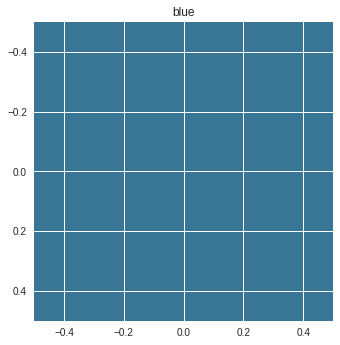

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Give me a color name (or press 'enter' to exit): 


<IPython.core.display.Javascript object>

In [19]:
tb = widgets.TabBar(["RNN Colorbot"])
while True:
  with tb.output_to(0):
    try:
      color_name = six.moves.input(
          "Give me a color name (or press 'enter' to exit): ")
    except (EOFError, KeyboardInterrupt):
      break
  if not color_name:
    break
  _, chars, length = parse(color_name)
  preds, = model((np.expand_dims(chars, 0), np.expand_dims(length, 0)),
                 training=False)
  clipped_preds = tuple(min(float(p), 1.0) for p in preds)
  rgb = tuple(int(p * 255) for p in clipped_preds)
  with tb.output_to(0):
    tb.clear_tab()
    print("Predicted RGB tuple:", rgb)
    plt.imshow([[clipped_preds]])
    plt.title(color_name)
    plt.show()

# 4. Exercises

### Exercise 1: Batching

Executing operations eagerly incurs small overheads; these overheads become neglible when amortized over batched operations. In this exercise, we explore the relationship between batching and performance by revisiting our Huber regression example.

In [0]:
# Our original implementation of `huber_loss` is not compatible with non-scalar
# data. Your task is to fix that. For your convenience, the original
# implementation is reproduced below.
#
#   def huber_loss(y, y_hat, m=1.0):
#     delta = tf.abs(y - y_hat)
#     return delta ** 2 if delta <= m else m * (2 * delta - m)
#
def batched_huber_loss(y, y_hat, m=1.0):
  # TODO: Uncomment out the below code and replace `...` with your solution.
  # Hint: Tensors are immutable.
  # Hint: `tf.where` might be useful.
  delta = tf.abs(y - y_hat)
  # ...
  # ...
  # return ...
  
regression = Regression(batched_huber_loss)

num_epochs = 4
batch_sizes = [1, 10, 20, 100, 200, 500, 1000]
times = []

X, Y = gen_regression_data(num_examples=1000)
dataset = tf.data.Dataset.from_tensor_slices((X, Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
for size in batch_sizes:
  batched_dataset = dataset.batch(size)
  start = time.time()
  regress(model=regression, optimizer=optimizer, dataset=batched_dataset,
          epochs=num_epochs, log_every=None)
  end = time.time()
  times.append((end - start) / num_epochs)
  regression.w.assign(0.0)
  regression.b.assign(0.0)
  
plt.figure()
plt.plot(batch_sizes, times, "bo")
plt.xlabel("batch size")
plt.ylabel("time (seconds)")
plt.semilogx()
plt.semilogy()
plt.title("Time per Epoch vs. Batch Size")
plt.show()

#### Solution

In [0]:
def batched_huber_loss(y, y_hat, m=1.0):
  delta = tf.abs(y - y_hat)
  quadratic = delta ** 2
  linear =  m * (2 * delta - m)
  return tf.reduce_mean(tf.where(delta <= m, quadratic, linear))
  
regression = Regression(batched_huber_loss)

num_epochs = 4
batch_sizes = [2, 10, 20, 100, 200, 500, 1000]
times = []

X, Y = gen_regression_data(num_examples=1000)
dataset = tf.data.Dataset.from_tensor_slices((X, Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
for size in batch_sizes:
  batched_dataset = dataset.batch(size)
  start = time.time()
  regress(model=regression, optimizer=optimizer, dataset=batched_dataset,
          epochs=num_epochs, log_every=None)
  end = time.time()
  times.append((end - start) / num_epochs)
  regression.w.assign(0.0)
  regression.b.assign(0.0)
  
plt.figure()
plt.plot(batch_sizes, times, "bo")
plt.xlabel("batch size")
plt.ylabel("time (seconds)")
plt.semilogx()
plt.semilogy()
plt.title("Time per Epoch vs. Batch Size")
plt.show()

### Exercise 2: Model Debugging

We've heard you loud and clear: TensorFlow programs that construct and execute graphs are difficult to debug. By design, enabling eager execution vastly simplifies the process of debugging TensorFlow programs. Once eager execution is enabled, you can step through your models using `pdb` and bisect them with `print` statements. The best way to understand the extent to which eager execution simplifies debugging is to debug a model yourself. `BuggyModel` below has two bugs lurking in it. Execute the following cell, read the error message, and go hunt some bugs!

*Hint: As is often the case with TensorFlow programs, both bugs are related to the shapes of Tensors.*

*Hint: You might find `tf.layers.flatten` useful.*

In [0]:
class BuggyModel(tf.keras.Model):
   def __init__(self):
    super(BuggyModel, self).__init__()
    self._input_shape = [-1, 28, 28, 1]
    self.conv = tf.layers.Conv2D(filters=32, kernel_size=5, padding="same",
                                 data_format="channels_last")
    self.fc = tf.layers.Dense(10)
    self.max_pool2d = tf.layers.MaxPooling2D(
        (2, 2), (2, 2), padding="same", data_format="channels_last")
    
  def call(self, inputs):
    y = inputs
    y = self.conv(y)
    y = self.max_pool2d(y)
    return self.fc(y)
  
buggy_model = BuggyModel()
inputs = tf.random_normal(shape=(100, 28, 28))
outputs = buggy_model(inputs)
assert outputs.shape == (100, 10), "invalid output shape: %s" % outputs.shape

#### Solution

In [0]:
class BuggyModel(tf.keras.Model):
  def __init__(self):
    super(BuggyModel, self).__init__()
    self._input_shape = [-1, 28, 28, 1]
    self.conv = tf.layers.Conv2D(filters=32, kernel_size=5, padding="same",
                                 data_format="channels_last")
    self.fc = tf.layers.Dense(10)
    self.max_pool2d = tf.layers.MaxPooling2D(
        (2, 2), (2, 2), padding="same", data_format="channels_last")
    
  def call(self, inputs):
    y = tf.reshape(inputs, self._input_shape)
    y = self.conv(y)
    y = self.max_pool2d(y)
    y = tf.layers.flatten(y)
    return self.fc(y)
  
buggy_model = BuggyModel()
inputs = tf.random_normal(shape=(100, 28, 28))
outputs = buggy_model(inputs)
assert outputs.shape == (100, 10), "invalid output shape: %s" % outputs.shape

# 5. Further reading

If you'd like to learn more about eager execution, consider reading ...



*   our [user guide](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/g3doc/guide.md);
*   our [collection of example models](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/eager/python/examples), which includes a convolutional model for [MNIST](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/eager/python/examples/mnist) classification, a [GAN](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/eager/python/examples/gan), a [recursive neural network](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/eager/python/examples/spinn), and more;
*  [this advanced notebook](https://colab.research.com/github/tensorflow/tensorflow/blob/master/tensorflow/contrib/autograph/examples/notebooks/dev_summit_2018_demo.ipynb), which explains how to build and execute graphs while eager execution is enabled and how to call into eager execution while constructing a graph, and which also introduces Autograph, a source-code translation tool that automatically generates graph-construction code from dynamic eager code.


